In [1]:
from skimage import io
import cv2 as cv2
from PIL import Image
import numpy as np
import os
import shutil

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from datasets import load_dataset
ds = load_dataset("F1nn21/playing-cards")

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

In [3]:
print(ds['train'][0])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=691x1056 at 0x14B750140>, 'label': 0}


(-0.5, 690.5, 1055.5, -0.5)

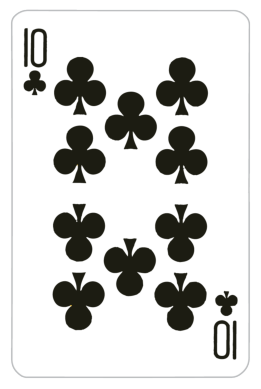

In [4]:
# Extract the image from the dataset
import matplotlib.pyplot as plt

# Convert the image to a format that can be displayed with matplotlib
image = ds['train'][0]['image']
plt.imshow(image)
plt.axis('off')  # Hide the axis


(691, 1056)


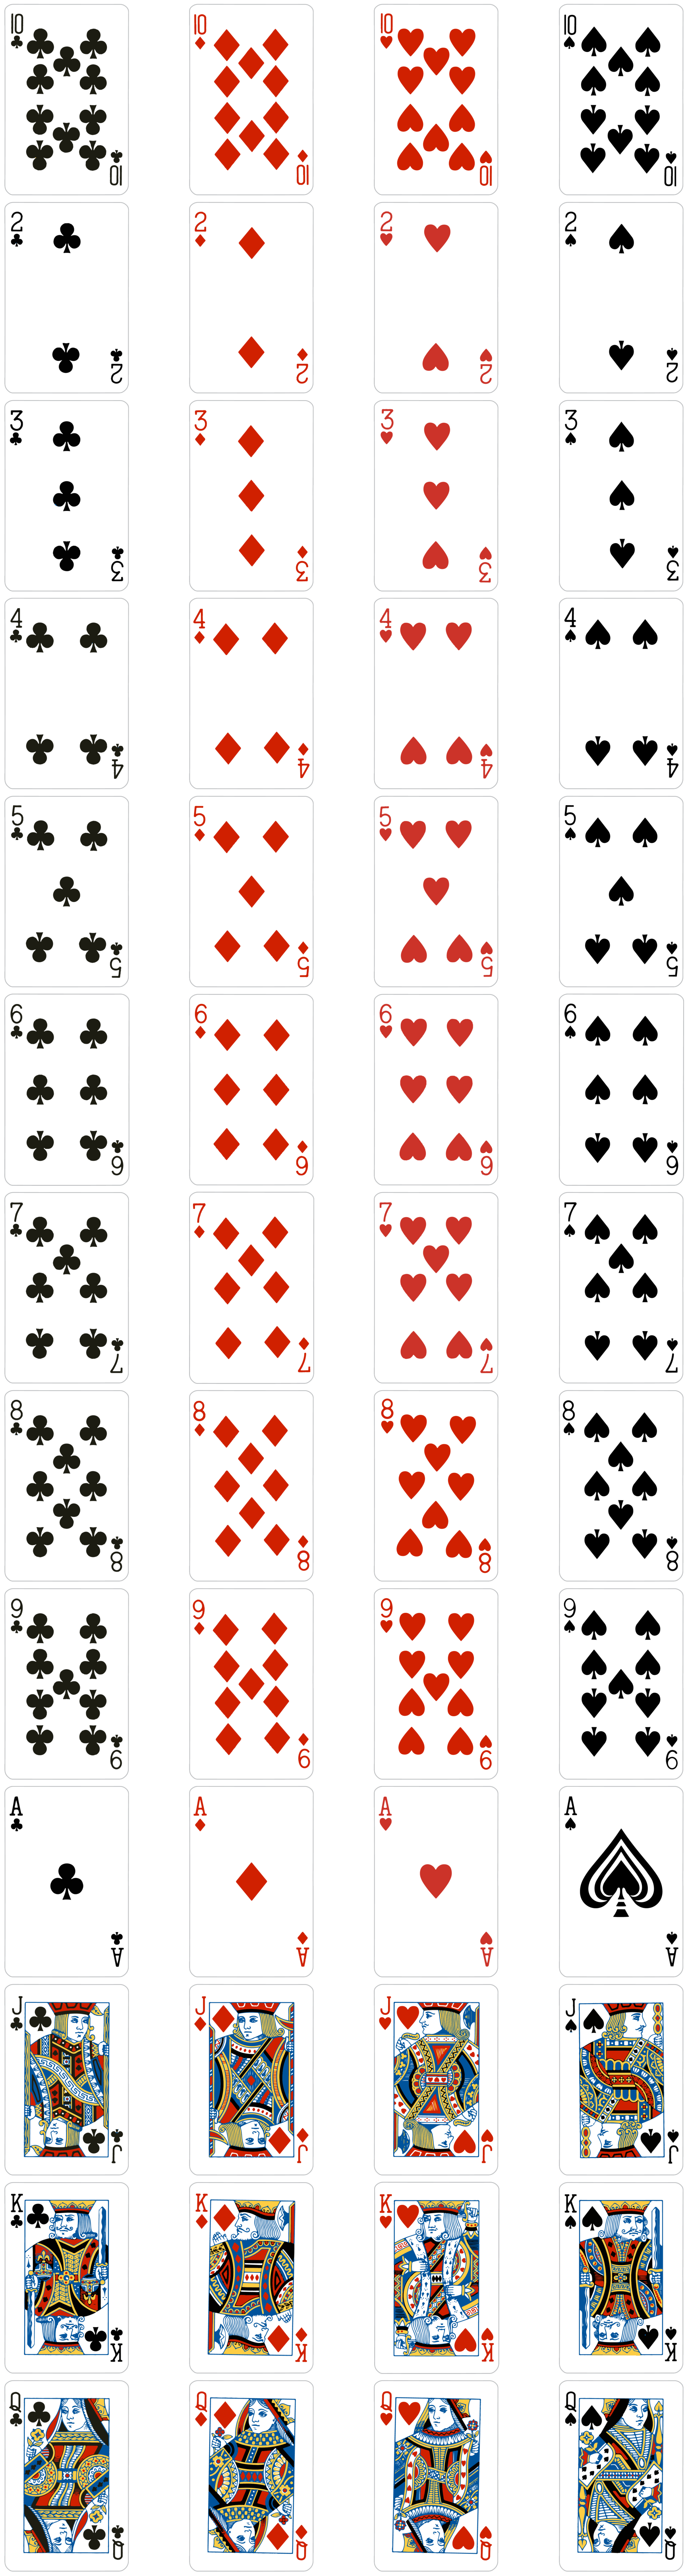

In [5]:
fig, axes = plt.subplots(13, 4, figsize=(20, 65))

for i, ax in enumerate(axes.flat):
    if i < len(ds['train']):
        image = ds['train'][i]['image']
        if i == 0:
            print(image.size)
        
        ax.imshow(image)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

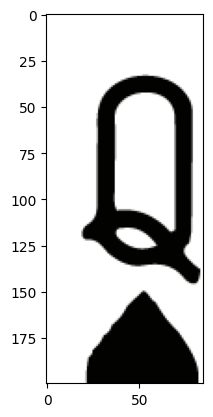

In [6]:
# Display just a part of the image
cropped_image = image.crop((15, 30, 100, 230))
plt.imshow(cropped_image)
plt.show()

(691, 1056)


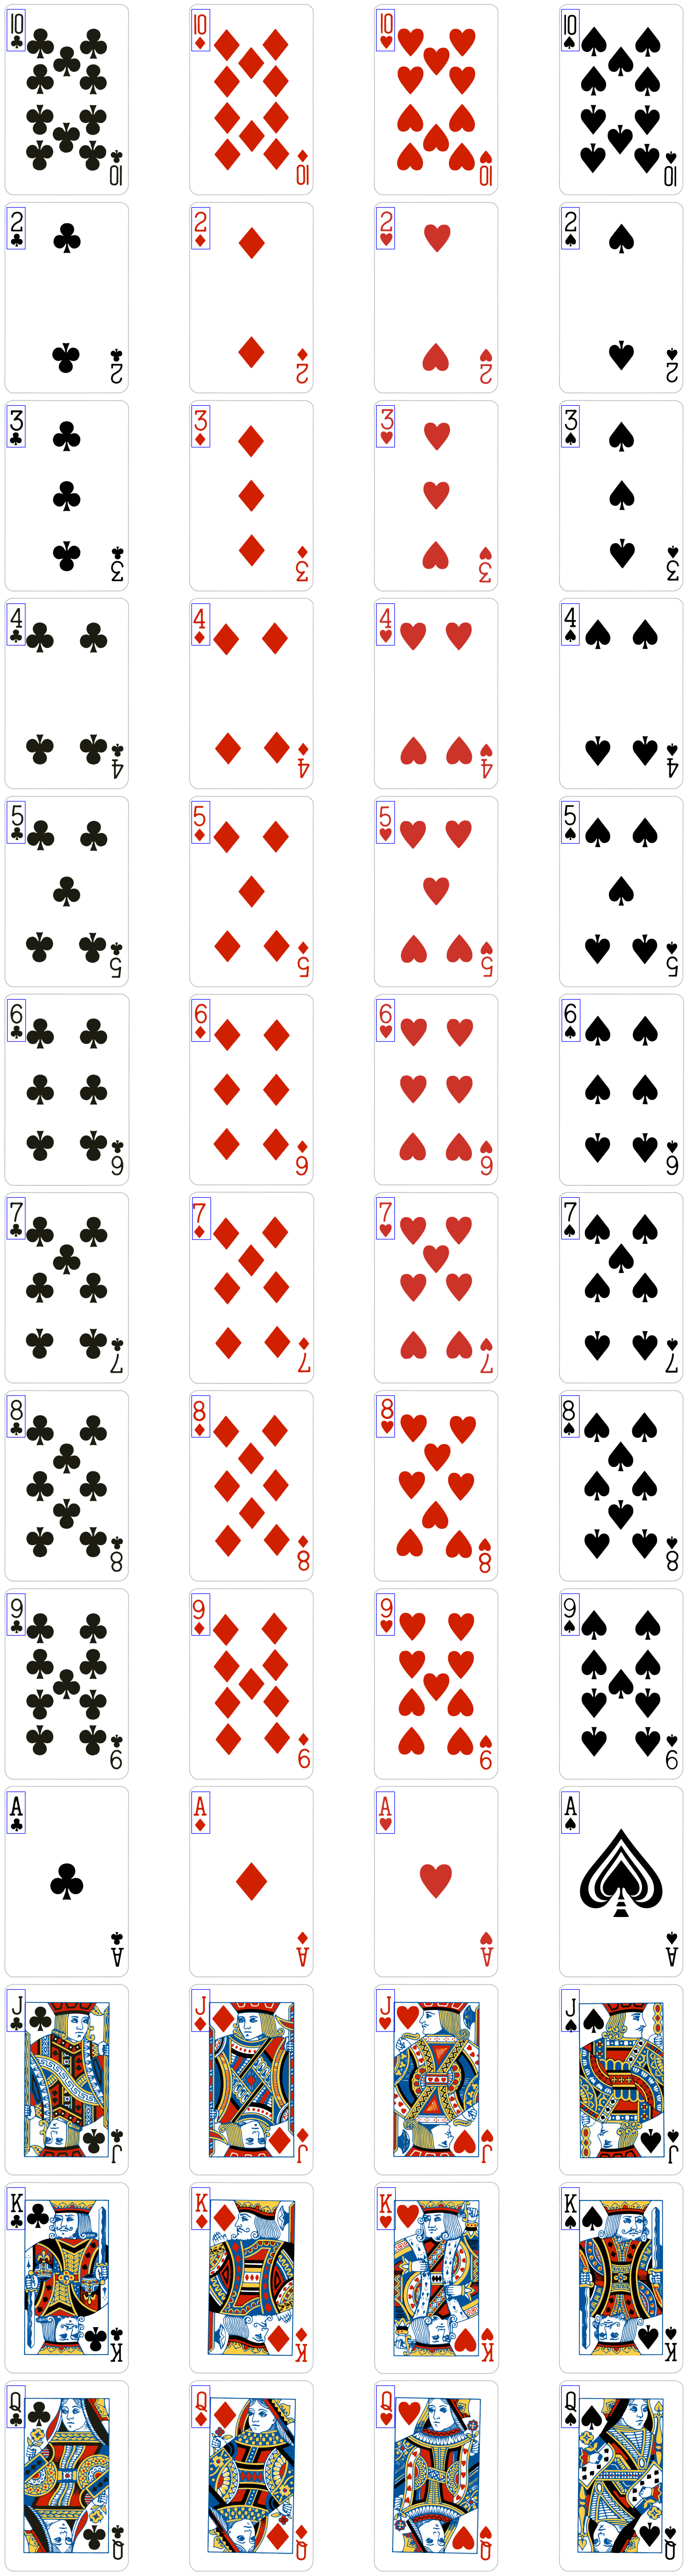

In [7]:
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(13, 4, figsize=(20, 65))

for i, ax in enumerate(axes.flat):
    if i < len(ds['train']):
        image = ds['train'][i]['image']
        
        if i == 0:
            print(image.size)
        
        ax.imshow(image)
        rect = Rectangle((15, 30), 100, 230, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device

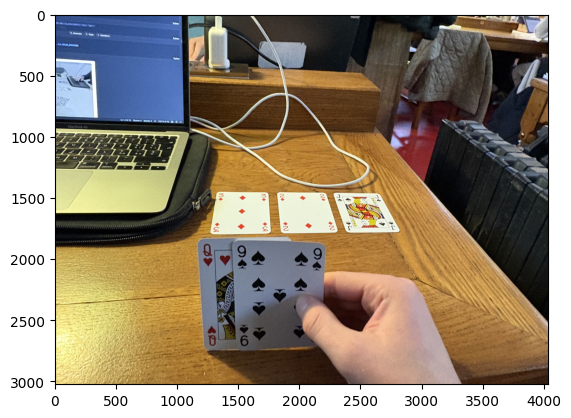

In [3]:
image_path = "../IMG_0030.jpeg"

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [4]:
def rgb2gray(img):
    gray = img.copy()
    gray[:, :, 0] = .299 * img[:, :, 0] + .587 * img[:, :, 1] + .114 * img[:, :, 2]
    gray[:, :, 1] = .299 * img[:, :, 0] + .587 * img[:, :, 1] + .114 * img[:, :, 2]
    gray[:, :, 2] = .299 * img[:, :, 0] + .587 * img[:, :, 1] + .114 * img[:, :, 2]
    return gray

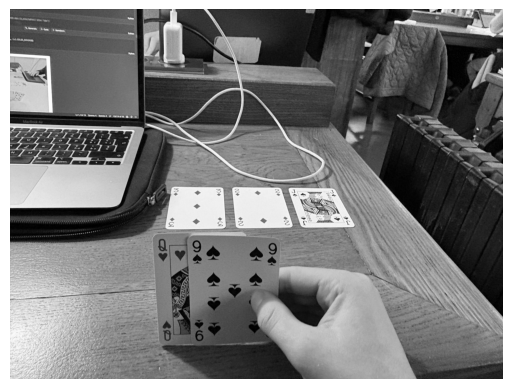

In [5]:
gray = rgb2gray(image)
plt.imshow(gray)
plt.axis('off')
plt.show()

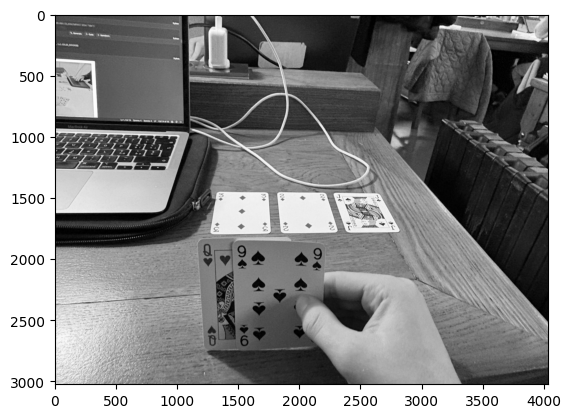

In [6]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred)

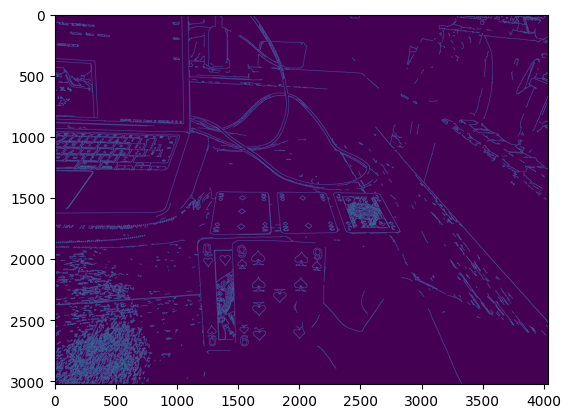

In [7]:
edges = cv2.Canny(blurred, 50, 150)
plt.imshow(edges)

In [8]:
from matplotlib.animation import FuncAnimation

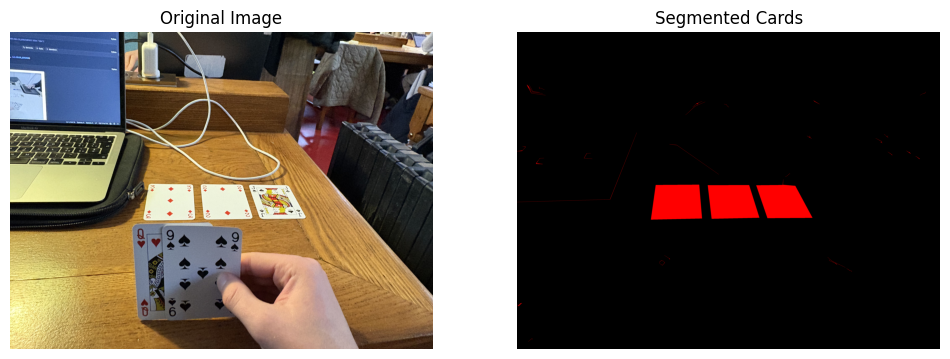

In [14]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros_like(gray)
A_list = []
for contour in contours:

    epsilon = 0.02 * cv2.arcLength(contour, True)
    poly = cv2.approxPolyDP(contour, epsilon, True) # Approximate a polygon based on the contour

    if 4 <= len(poly) <= 8: # Becuase of approximation we check if the polygon has a number of polygons between 4 and 8
        x, y, w, h = cv2.boundingRect(poly) 
        aspect_ratio = w / float(h)
        A = w * h

        if A >= 1000 and 1.3 <= aspect_ratio <= 1.8:
            cv2.drawContours(mask, [poly], -1, 255, -1) 


plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Segmented Mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Segmented Cards")
plt.axis('off')

plt.show()


In [54]:
def segment_cards(image_path:str, plot:bool=True) -> np.array:

    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    gray = rgb2gray(img)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(gray)
    for contour in contours:

        epsilon = 0.02 * cv2.arcLength(contour, True)
        poly = cv2.approxPolyDP(contour, epsilon, True) # Approximate a polygon based on the contour

        if 4 <= len(poly):
            _, _, w, h = cv2.boundingRect(poly) 
            aspect_ratio = w / float(h)

            if 1 <= aspect_ratio <= 1.8:
                cv2.drawContours(mask, [poly], -1, 255, 5) 

    if plot:
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        # Segmented Mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Segmented Cards")
        plt.axis('off')

        plt.show()
    
    return mask

In [24]:
path_name = '../shared_data/kaggle_playing_card_ataset/Images/Images/'

In [25]:
img_paths = []
for filename in os.listdir(path_name):
    if filename.endswith(".jpg"):
        img_path = path_name + filename
        img_paths.append(img_path)

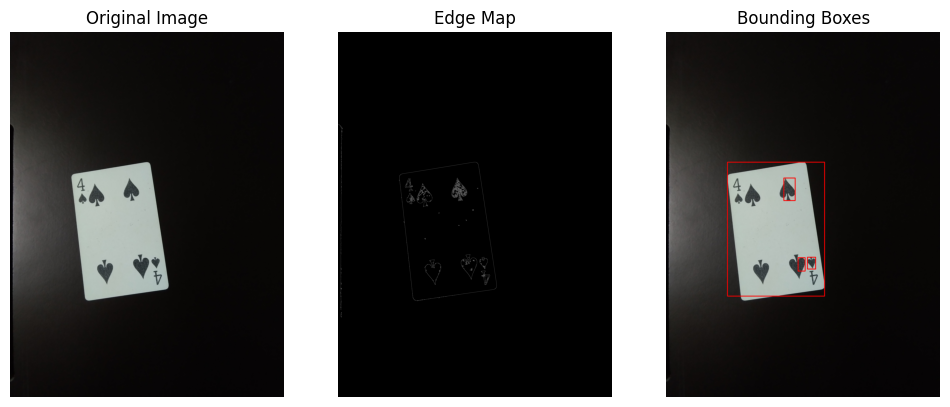

Bounding Boxes: [(1666, 2849, 89, 169), (1784, 2843, 103, 149), (1486, 1843, 143, 285), (775, 1643, 1225, 1691)]


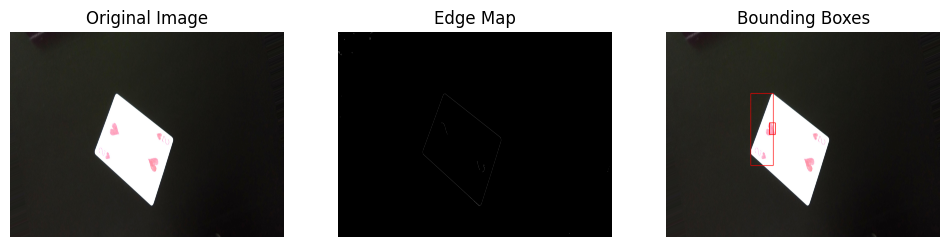

Bounding Boxes: [(1741, 1540, 97, 197), (1427, 1048, 376, 1209)]


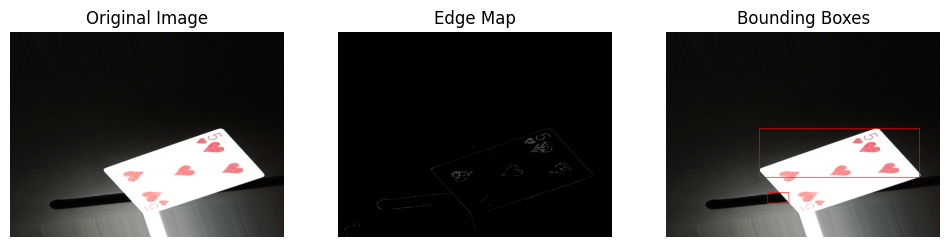

Bounding Boxes: [(1712, 2712, 355, 175), (1575, 1636, 2690, 820)]


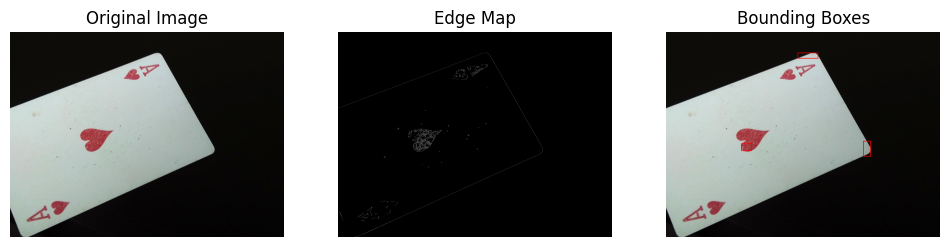

Bounding Boxes: [(1270, 1889, 167, 118), (3319, 1848, 123, 253), (2218, 367, 338, 91)]


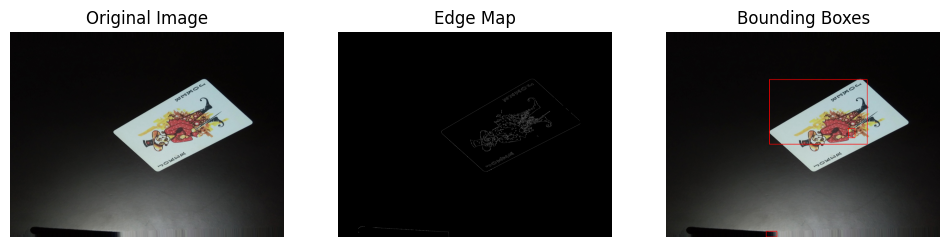

Bounding Boxes: [(1684, 3359, 182, 97), (3065, 1636, 113, 155), (1740, 814, 1643, 1085)]


In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for visualization

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply CLAHE for better contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # Edge detection using Canny
    edges = cv2.Canny(gray, 50, 250)
    return image, gray, edges


def find_card_contours(edges):
    # Find contours in the edge map
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    card_contours = []
    bounding_boxes = []

    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Filter by shape (4 vertices) and area
        if len(approx) >= 4:
            card_contours.append(approx)

            # Compute bounding box
            x, y, w, h = cv2.boundingRect(approx)
            if w * h > 15000:
                bounding_boxes.append((x, y, w, h))

    return card_contours, bounding_boxes


def draw_bounding_boxes(image, bounding_boxes):
    # Draw bounding boxes on the image
    boxed_image = image.copy()
    for (x, y, w, h) in bounding_boxes:
        cv2.rectangle(boxed_image, (x, y), (x + w, y + h), (255, 0, 0), 10) 
    return boxed_image


def plot_results(image, edges, boxed_image):
    # Plot original image, edge map, and image with bounding boxes
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # Edge Map
    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Map")
    plt.axis("off")

    # Image with Bounding Boxes
    plt.subplot(1, 3, 3)
    plt.imshow(boxed_image)
    plt.title("Bounding Boxes")
    plt.axis("off")

    plt.show()


for path in img_paths[:5]:
    image_path = path
    image, gray, edges = preprocess_image(image_path)
    contours, bounding_boxes = find_card_contours(edges)
    boxed_image = draw_bounding_boxes(image, bounding_boxes)
    plot_results(image, edges, boxed_image)
    print("Bounding Boxes:", bounding_boxes)